In [167]:

import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim import corpora, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models import word2vec
from sklearn.decomposition import LatentDirichletAllocation


from keras.preprocessing.text import Tokenizer
import tensorflow as tf

In [168]:
data = pd.read_csv("/kaggle/input/disability-data/ID dataset0.CSV", encoding="ISO-8859-1")
data_2 = pd.read_csv("/kaggle/input/disability-data/Down Syndrome Dataset0.csv", encoding="ISO-8859-1")

In [169]:
data.head()

,username,user_description,tweet,is_retweet
0,cosmicfizzypop,dnfi if youre nsfw,sometimes i wish i didnt have a learning disa...,Yes
1,Naltonpi,Fat Falco and Joker. I enjoy both Yugioh and S...,I have a learning disability. It'scalled Heart...,No
2,arminiu_ss,Cogito Ergo Sum,We all are intellectually challenged to some e...,Yes
3,KiwiFunknuckle,The original and only Kiwifunknuckle. Small fl...,I really struggled to read and write. I repeat...,Yes
4,CatherineHorbu3,I am a Peer Support worker for learning disabi...,I am proud of being a woman with a lived exper...,Yes


In [170]:
data_2.head()

,username,user_description,tweet,is_retweet
0,baker_banter,"Hi! My name is Derek, I am 23, I have Down syn...",HAPPY WORLD DOWN SYNDROME DAY AND HAPPY 2nd BI...,No
1,MaxAPeters,Max Peters is a dynamic young man with Down Sy...,World Down Syndrome Day is coming up March 21!...,Yes
2,MikaylaHDancer,I am a self advocate. I am the first woman wit...,I had so much fun at Down syndrome conference ...,No
3,DiedraMckesson,My name is Diedra Mckesson I have Down Syndro...,Would bring awareness about the importance of ...,Yes
4,clbagelboy,I am an KMR/SAG Actor who has Down syndrome. I...,Happy Disability Pride Month!! I am so happy t...,No


In [171]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Preprocessing

In [172]:
def clean_text(text):
    '''
        Make text lowercase, remove text in square brackets,remove links,remove punctuation
        and remove words containing numbers.
    '''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [173]:
# Defining a function to remove emoji's
def removeEmoji(text):
    emoji = re.compile(
        "["
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F600-\U0001F64F"  # emotion icons
        u"\U0001F1E0-\U0001F1FF"  # flags
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )
    return emoji.sub(r'', text)

# LDA Model and Topic Modelling

In [174]:
#Apply preprocessing to the two datasets
data = data.dropna(subset=['tweet'])
data['clean_text'] = data['tweet'].apply(clean_text)
data_2 = data_2.dropna(subset=['tweet'])
data_2['clean_text'] = data_2['tweet'].apply(clean_text)

In [175]:
#create dictionary for the datasets
documents_data = [text.split() for text in data['clean_text']]

data_dictionary = corpora.Dictionary(documents_data)

documents_data_2 = [text.split() for text in data['clean_text']]

data_2_dictionary = corpora.Dictionary(documents_data_2)

# Convert thedataset into a  bag-of-words (BoW) representation
data_corpus = [data_dictionary.doc2bow(doc) for doc in documents_data]
data_2_corpus = [data_2_dictionary.doc2bow(doc) for doc in documents_data_2]



In [176]:
# Train the LDA models for each dataset
num_topics = 20  

data_lda_model = models.LdaModel(data_corpus, num_topics=num_topics, id2word=data_dictionary, passes=10)
data_2_lda_model = models.LdaModel(data_2_corpus, num_topics=num_topics, id2word=data_2_dictionary, passes=10)



In [177]:
# Print the topics and keywords for Williams syndrome and Intellectual disability
print("ID dataset Topics:")
for idx, topic in data_lda_model.print_topics(-1):
    print(f'Topic {idx + 1}: {topic}')



ID dataset Topics:
Topic 1: 0.070*"i" + 0.056*"a" + 0.056*"disability" + 0.042*"have" + 0.042*"and" + 0.028*"learning" + 0.028*"female" + 0.014*"find" + 0.014*"grassroots" + 0.014*"turn"
Topic 2: 0.108*"i" + 0.052*"a" + 0.035*"disability" + 0.035*"have" + 0.026*"the" + 0.023*"learning" + 0.020*"and" + 0.019*"in" + 0.019*"so" + 0.019*"is"
Topic 3: 0.059*"i" + 0.047*"a" + 0.047*"and" + 0.036*"have" + 0.036*"disability" + 0.024*"learning" + 0.024*"for" + 0.024*"but" + 0.024*"think" + 0.024*"just"
Topic 4: 0.058*"have" + 0.044*"syndrome" + 0.044*"william" + 0.030*"with" + 0.030*"i" + 0.030*"a" + 0.029*"rare" + 0.029*"individuals" + 0.029*"disorder" + 0.015*"my"
Topic 5: 0.087*"the" + 0.073*"as" + 0.029*"it" + 0.029*"well" + 0.029*"deformities" + 0.029*"a" + 0.029*"of" + 0.015*"that" + 0.015*"such" + 0.015*"intellectual"
Topic 6: 0.059*"a" + 0.058*"i" + 0.035*"have" + 0.028*"and" + 0.025*"of" + 0.019*"disability" + 0.019*"in" + 0.019*"love" + 0.019*"syndrome" + 0.019*"so"
Topic 7: 0.068*"to

In [178]:
# Print the topics and keywords for down syndrome

print("Down Syndrome Dataset Topics:")
for idx, topic in data_2_lda_model.print_topics(-1):
    print(f'Topic {idx + 1}: {topic}')

Down Syndrome Dataset Topics:
Topic 1: 0.058*"i" + 0.030*"disability" + 0.030*"and" + 0.030*"learning" + 0.030*"misread" + 0.030*"ott" + 0.030*"thank" + 0.030*"bec" + 0.030*"of" + 0.030*"go"
Topic 2: 0.054*"to" + 0.043*"ld" + 0.041*"got" + 0.040*"with" + 0.038*"i" + 0.029*"proud" + 0.029*"no" + 0.029*"box" + 0.029*"ticketing" + 0.029*"voice"
Topic 3: 0.075*"i" + 0.035*"disability" + 0.030*"a" + 0.030*"and" + 0.030*"my" + 0.020*"so" + 0.020*"me" + 0.020*"have" + 0.020*"in" + 0.015*"learning"
Topic 4: 0.044*"i" + 0.033*"a" + 0.033*"too" + 0.022*"have" + 0.022*"of" + 0.022*"disabled" + 0.022*"the" + 0.022*"disability" + 0.022*"it" + 0.022*"me"
Topic 5: 0.084*"and" + 0.075*"a" + 0.058*"i" + 0.039*"to" + 0.033*"disability" + 0.026*"of" + 0.025*"learning" + 0.025*"have" + 0.017*"being" + 0.017*"love"
Topic 6: 0.043*"bee" + 0.043*"the" + 0.043*"city" + 0.043*"in" + 0.002*"i" + 0.002*"a" + 0.002*"much" + 0.002*"called" + 0.002*"fan" + 0.002*"it"
Topic 7: 0.002*"zoom" + 0.002*"crew" + 0.002*"sp

In [179]:
# dominant topics for in the datasets
print("ID Dataset Dominant Topics:")
for i, row in enumerate(data_lda_model[data_corpus]):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    print(f"Document {i + 1}: Topic {row[0][0] + 1} (Probability: {row[0][1]})")

print("Down Syndrome Dataset Dominant Topics:")
for i, row in enumerate(data_2_lda_model[data_2_corpus]):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    print(f"Document {i + 1}: Topic {row[0][0] + 1} (Probability: {row[0][1]})")

ID Dataset Dominant Topics:
Document 1: Topic 2 (Probability: 0.9406235814094543)
Document 2: Topic 2 (Probability: 0.5346310138702393)
Document 3: Topic 17 (Probability: 0.9693542718887329)
Document 4: Topic 2 (Probability: 0.9773803353309631)
Document 5: Topic 6 (Probability: 0.9817304015159607)
Document 6: Topic 12 (Probability: 0.9762497544288635)
Document 7: Topic 13 (Probability: 0.9793475866317749)
Document 8: Topic 2 (Probability: 0.9568173289299011)
Document 9: Topic 1 (Probability: 0.8416655659675598)
Document 10: Topic 5 (Probability: 0.9809998273849487)
Document 11: Topic 9 (Probability: 0.819149911403656)
Document 12: Topic 9 (Probability: 0.9472213387489319)
Document 13: Topic 9 (Probability: 0.9406240582466125)
Document 14: Topic 20 (Probability: 0.9768290519714355)
Document 15: Topic 15 (Probability: 0.9568179845809937)
Document 16: Topic 13 (Probability: 0.8099983334541321)
Document 17: Topic 17 (Probability: 0.9836204648017883)
Document 18: Topic 6 (Probability: 0.976

In [180]:
# data['Text'] = data['Text'].astype(str)
data['tweet'] = data['tweet'].apply(lambda x: clean_text(x))


data['tweet']=data['tweet'].apply(lambda x: removeEmoji(x))
data['tweet'].apply(lambda x:len(str(x).split())).max()

57

In [181]:
data['tweet'].head()

0    sometimes i wish i didnt have a learning disa...
1    i have a learning disability itscalled heart o...
2    we all are intellectually challenged to some e...
3    i really struggled to read and write i repeate...
4    i am proud of being a woman with a lived exper...
Name: tweet, dtype: object

In [182]:
data_2['tweet'] = data_2['tweet'].apply(lambda x: clean_text(x))

data_2['tweet']=data_2['tweet'].apply(lambda x: removeEmoji(x))
data_2['tweet'].apply(lambda x:len(str(x).split())).max()

44

In [183]:
data_2['tweet'][20:80]

20    gracie got a gift today her days of playing wi...
21    whos counting down the days to the national do...
22    i just signed up for national down syndrome co...
23    endometriosis has a significant social and psy...
24    i have developmental disability and for short ...
25    somebody pinch me look what the absolutely ama...
26    busting myth about downsyndrome the full campa...
27    can anyone  help me understand why why ppl lik...
28    currently  e or fiat equivalent  support the f...
29    can anyone  help me understand why why ppl lik...
30    my name is demi this is my twitter i have down...
31    global president  ceo michelle sie whitten wil...
32    peace love acceptance  happy world down syndro...
33                                    how great is this
34    down syndrome advocates enjoy prom night toget...
35    i am single sided deaf i have experience with ...
36                        happy world down syndrome day
Name: tweet, dtype: object

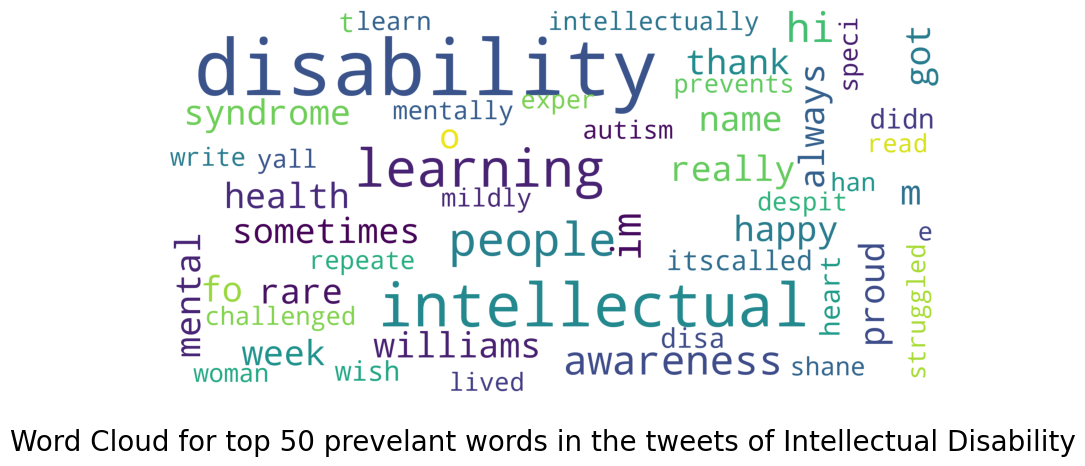

In [184]:
 word_cloud = WordCloud(
     background_color='white',
     stopwords=set(STOPWORDS),
     max_words=50,
     max_font_size=40,
     scale=5,
     random_state=1
 ).generate(str(data['tweet']))

fig = plt.figure(1, figsize=(10,10))
plt.axis('off')
fig.suptitle('Word Cloud for top 50 prevelant words in the tweets of Intellectual Disability', fontsize=20)
fig.subplots_adjust(top=2.3)
plt.imshow(word_cloud)
plt.show()

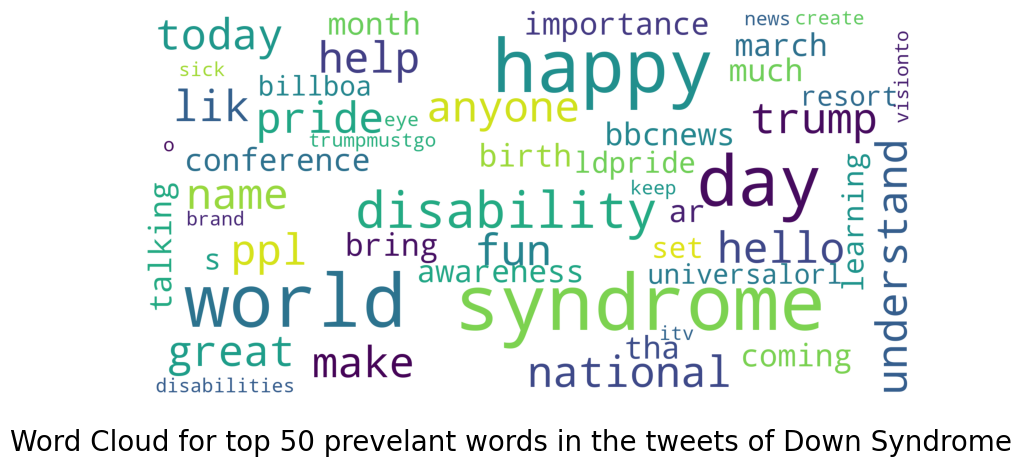

In [185]:
 word_cloud = WordCloud(
     background_color='white',
     stopwords=set(STOPWORDS),
     max_words=50,
     max_font_size=40,
     scale=5,
     random_state=1
 ).generate(str(data_2['tweet']))

fig = plt.figure(1, figsize=(10,10))
plt.axis('off')
fig.suptitle('Word Cloud for top 50 prevelant words in the tweets of Down Syndrome', fontsize=20)
fig.subplots_adjust(top=2.3)
plt.imshow(word_cloud)
plt.show()

# Sentiment Labelling

In [186]:
nltk.download("vader_lexicon")

sentiments = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [187]:
data["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in data["tweet"]]
data["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in data["tweet"]]
data["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in data["tweet"]]
data['Compound'] = [sentiments.polarity_scores(i)["compound"] for i in data["tweet"]]

In [188]:
# Labeling sentiments into the dataset

score = data["Compound"].values
sentiment = []
for i in score:
    if i >= 0.05 :
        sentiment.append('Positive')
    elif i <= -0.05 :
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
data["Sentiment"] = sentiment

In [189]:
data.head()

,username,user_description,tweet,is_retweet,clean_text,Positive,Negative,Neutral,Compound,Sentiment
0,cosmicfizzypop,dnfi if youre nsfw,sometimes i wish i didnt have a learning disa...,Yes,sometimes i wish i didnt have a learning disa...,0.158,0.256,0.586,-0.3952,Negative
1,Naltonpi,Fat Falco and Joker. I enjoy both Yugioh and S...,i have a learning disability itscalled heart o...,No,i have a learning disability itscalled heart o...,0.000,0.000,1.000,0.0000,Neutral
2,arminiu_ss,Cogito Ergo Sum,we all are intellectually challenged to some e...,Yes,we all are intellectually challenged to some e...,0.201,0.156,0.643,0.3506,Positive
3,KiwiFunknuckle,The original and only Kiwifunknuckle. Small fl...,i really struggled to read and write i repeate...,Yes,i really struggled to read and write i repeate...,0.160,0.046,0.794,0.6812,Positive
4,CatherineHorbu3,I am a Peer Support worker for learning disabi...,i am proud of being a woman with a lived exper...,Yes,i am proud of being a woman with a lived exper...,0.268,0.000,0.732,0.9312,Positive


<Axes: xlabel='Sentiment', ylabel='count'>

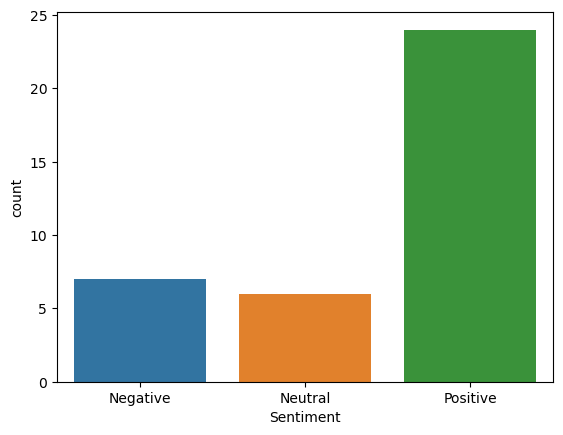

In [190]:
sns.countplot(data=data, x='Sentiment')

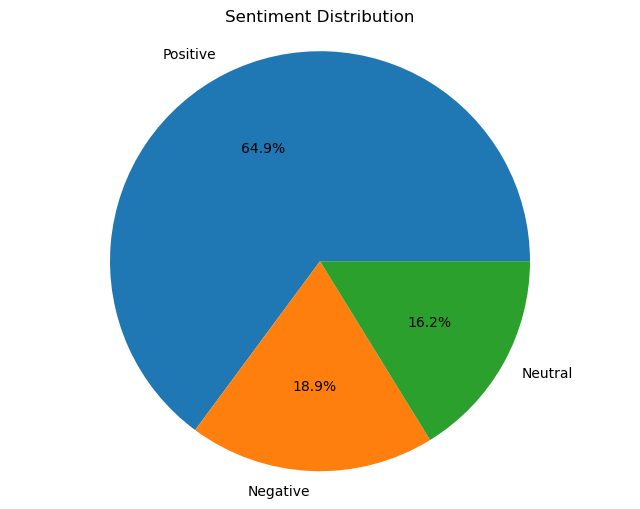

In [191]:
sentiment_counts = data["Sentiment"].value_counts()
sentiment_percentages = (sentiment_counts / len(data)) * 100

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sentiment_percentages, labels=sentiment_percentages.index, autopct='%1.1f%%')
plt.title("Sentiment Distribution")
plt.axis('equal')
plt.show()

In [192]:
data_2["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in data_2["tweet"]]
data_2["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in data_2["tweet"]]
data_2["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in data_2["tweet"]]
data_2['Compound'] = [sentiments.polarity_scores(i)["compound"] for i in data_2["tweet"]]

In [193]:
# Labeling sentiments into the dataset

score = data_2["Compound"].values
sentiment = []
for i in score:
    if i >= 0.05 :
        sentiment.append('Positive')
    elif i <= -0.05 :
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
data_2["Sentiment"] = sentiment

In [194]:
data_2.head()

,username,user_description,tweet,is_retweet,clean_text,Positive,Negative,Neutral,Compound,Sentiment
0,baker_banter,"Hi! My name is Derek, I am 23, I have Down syn...",happy world down syndrome day and happy birth...,No,happy world down syndrome day and happy birth...,0.401,0.076,0.523,0.9287,Positive
1,MaxAPeters,Max Peters is a dynamic young man with Down Sy...,world down syndrome day is coming up march ar...,Yes,world down syndrome day is coming up march ar...,0.094,0.000,0.906,0.3612,Positive
2,MikaylaHDancer,I am a self advocate. I am the first woman wit...,i had so much fun at down syndrome conference ...,No,i had so much fun at down syndrome conference ...,0.206,0.000,0.794,0.8620,Positive
3,DiedraMckesson,My name is Diedra Mckesson I have Down Syndro...,would bring awareness about the importance of ...,Yes,would bring awareness about the importance of ...,0.161,0.064,0.775,0.5023,Positive
4,clbagelboy,I am an KMR/SAG Actor who has Down syndrome. I...,happy disability pride month i am so happy tha...,No,happy disability pride month i am so happy tha...,0.600,0.000,0.400,0.9260,Positive


<Axes: xlabel='Sentiment', ylabel='count'>

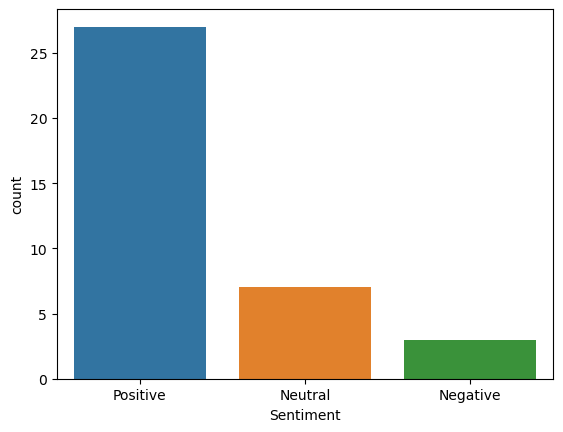

In [195]:
sns.countplot(data=data_2, x='Sentiment')

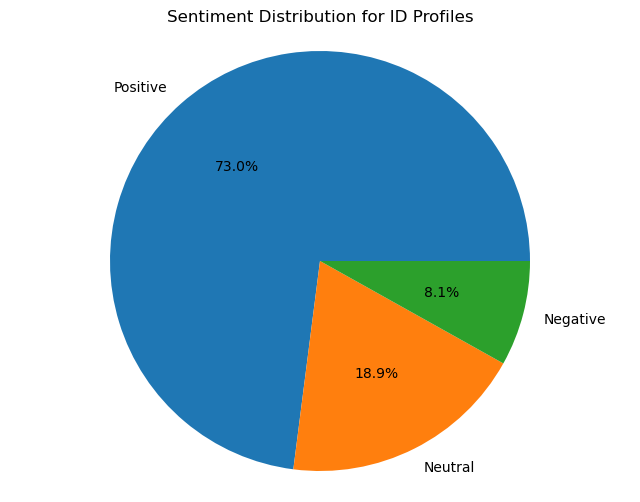

In [196]:
# Calculate sentiment percentages
sentiment_counts = data_2["Sentiment"].value_counts()
sentiment_percentages = (sentiment_counts / len(data_2)) * 100

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sentiment_percentages, labels=sentiment_percentages.index, autopct='%1.1f%%')
plt.title("Sentiment Distribution for ID Profiles")
plt.axis('equal')
plt.show()

# 

# Model Training

In [197]:
lb= LabelEncoder()

lb.fit(data['Sentiment'])

LabelEncoder()

In [198]:
y_train_down_syndrome = lb.transform(data['Sentiment'].to_list())

In [199]:
y_train_idd = lb.transform(data_2['Sentiment'].to_list())

In [200]:
# Splits Dataset into Training and Testing set
x_train_down_syndrome, x_test_down_syndrome, y_train_down_syndrome, y_test_down_syndrome = train_test_split(
    data["tweet"], y_train_down_syndrome, test_size=0.2, random_state=7
)

In [201]:
# Splits Dataset into Training and Testing set
x_train_idd, x_test_idd, y_train_idd, y_test_idd = train_test_split(
    data_2["tweet"], y_train_idd, test_size=0.2, random_state=7
)

# Transformer Classification Model

In [202]:
MAX_SEQUENCE_LENGTH = 40

In [203]:
down_syndrome_tokenizer = Tokenizer()
down_syndrome_tokenizer.fit_on_texts(data.tweet)

word_index_down_syndrome = down_syndrome_tokenizer.word_index
vocab_size_down_syndrome = len(down_syndrome_tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size_down_syndrome)

Vocabulary Size : 411


In [204]:
x_train_down_syndrome = tf.keras.utils.pad_sequences(down_syndrome_tokenizer.texts_to_sequences(x_train_down_syndrome.ravel()), maxlen=MAX_SEQUENCE_LENGTH)
x_test_down_syndrome = tf.keras.utils.pad_sequences(down_syndrome_tokenizer.texts_to_sequences(x_test_down_syndrome.ravel()), maxlen=MAX_SEQUENCE_LENGTH)

In [205]:
idd_tokenizer = Tokenizer()
idd_tokenizer.fit_on_texts(data_2.tweet)

word_index_idd = idd_tokenizer.word_index
vocab_size_idd = len(idd_tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size_idd)

Vocabulary Size : 382


In [206]:
x_train_idd = tf.keras.utils.pad_sequences(idd_tokenizer.texts_to_sequences(x_train_idd.ravel()), maxlen=MAX_SEQUENCE_LENGTH)
x_test_idd = tf.keras.utils.pad_sequences(idd_tokenizer.texts_to_sequences(x_test_idd.ravel()), maxlen=MAX_SEQUENCE_LENGTH)

In [207]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer
from tensorflow.keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [208]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), 
             Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [209]:
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [210]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = TokenAndPositionEmbedding(MAX_SEQUENCE_LENGTH, vocab_size_down_syndrome, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
x = Dropout(0.1)(x)
outputs = Dense(3, activation="softmax")(x)

model_down_syndrome = Model(inputs=inputs, outputs=outputs)

In [211]:
model_down_syndrome.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [212]:
ReduceLROnPlateau_ = ReduceLROnPlateau(factor=0.1, min_lr = 0.01, monitor = 'val_loss', verbose = 1)
history_transformer = model_down_syndrome.fit(
    x_train_down_syndrome, y_train_down_syndrome, batch_size=32, epochs=10,
    validation_data=(x_test_down_syndrome, y_test_down_syndrome), callbacks=[ReduceLROnPlateau_]
)

Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.9178 - accuracy: 0.6897 - val_loss: 0.9611 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
1/1 [==============================] - 0s 80ms/step - loss: 0.8717 - accuracy: 0.6897 - val_loss: 1.0037 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/10
1/1 [==============================] - 0s 58ms/step - loss: 0.8154 - accuracy: 0.6897 - val_loss: 1.0128 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/10
1/1 [==============================] - 0s 50ms/step - loss: 0.7935 - accuracy: 0.6897 - val_loss: 0.9796 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/10
1/1 [==============================] - 0s 51ms/step - loss: 0.6679 - accuracy: 0.6897 - val_loss: 0.9437 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/10
1/1 [==============================] - 0s 49ms/step - loss: 0.6712 - accuracy: 0.6897 - val_loss: 0.9106 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/10
1/1 [==============================] - 0s 53ms/step - loss: 0.6434 - accuracy: 

In [213]:
scores_down_syndrome = model_down_syndrome.predict(x_test_down_syndrome, verbose=1, batch_size=10000)
pred_down_syndrome = np.argmax(scores_down_syndrome, axis=1)
report_down_syndrome = classification_report(y_test_down_syndrome, pred_down_syndrome, output_dict=True)

1/1 [==============================] - 0s 227ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [214]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = TokenAndPositionEmbedding(MAX_SEQUENCE_LENGTH, vocab_size_idd, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
x = Dropout(0.1)(x)
outputs = Dense(3, activation="softmax")(x)

model_idd = Model(inputs=inputs, outputs=outputs)

In [215]:
model_idd.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [216]:
ReduceLROnPlateau_idd = ReduceLROnPlateau(factor=0.1, min_lr = 0.01, monitor = 'val_loss', verbose = 1)
history_transformer_idd = model_idd.fit(
    x_train_idd, y_train_idd, batch_size=32, epochs=10,
    validation_data=(x_test_idd, y_test_idd), callbacks=[ReduceLROnPlateau_idd]
)

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 1.1938 - accuracy: 0.2069 - val_loss: 0.8194 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 2/10
1/1 [==============================] - 0s 53ms/step - loss: 1.0449 - accuracy: 0.5517 - val_loss: 0.6003 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 3/10
1/1 [==============================] - 0s 49ms/step - loss: 0.7951 - accuracy: 0.6897 - val_loss: 0.4913 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 4/10
1/1 [==============================] - 0s 52ms/step - loss: 0.7828 - accuracy: 0.6552 - val_loss: 0.4533 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 5/10
1/1 [==============================] - 0s 65ms/step - loss: 0.7361 - accuracy: 0.6897 - val_loss: 0.4339 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 6/10
1/1 [==============================] - 0s 52ms/step - loss: 0.7447 - accuracy: 0.6897 - val_loss: 0.4322 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 7/10
1/1 [==============================] - 0s 48ms/step - loss: 0.6281 - accuracy: 

1/1 [==============================] - 0s 24ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

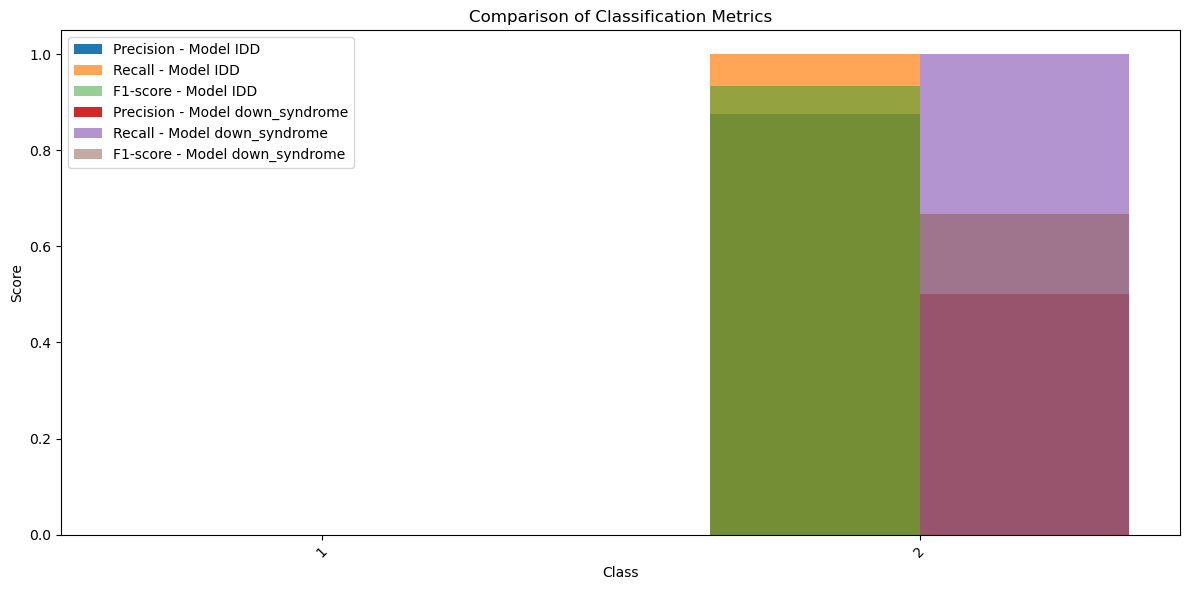

In [217]:
# Model 1 predictions
scores_model_idd = model_idd.predict(x_test_idd, verbose=1, batch_size=10000)
pred_model_idd = np.argmax(scores_model_idd, axis=1)
report_model_idd = classification_report(y_test_idd, pred_model_idd, output_dict=True)

# Model 2 predictions
scores_model_down_syndrome = model_down_syndrome.predict(x_test_down_syndrome, verbose=1, batch_size=10000)
pred_model_down_syndrome = np.argmax(scores_model_down_syndrome, axis=1)
report_model_down_syndrome = classification_report(y_test_down_syndrome, pred_model_down_syndrome, output_dict=True)

# Get class labels and metrics from the classification reports
class_labels = list(report_model_idd.keys())[:-3]  # Exclude 'accuracy', 'macro avg', and 'weighted avg'
precision_scores_model_idd = [report_model_idd[label]['precision'] for label in class_labels]
recall_scores_model_idd = [report_model_idd[label]['recall'] for label in class_labels]
f1_scores_model_idd = [report_model_idd[label]['f1-score'] for label in class_labels]

precision_scores_model_down_syndrome = [report_model_down_syndrome[label]['precision'] for label in class_labels]
recall_scores_model_down_syndrome = [report_model_down_syndrome[label]['recall'] for label in class_labels]
f1_scores_model_down_syndrome = [report_model_down_syndrome[label]['f1-score'] for label in class_labels]

# Create bar charts to visualize the metrics for both models
plt.figure(figsize=(12, 6))
x = range(len(class_labels))
width = 0.35

plt.bar(x, precision_scores_model_idd, width, label='Precision - Model IDD')
plt.bar(x, recall_scores_model_idd, width, label='Recall - Model IDD', alpha=0.7)
plt.bar(x, f1_scores_model_idd, width, label='F1-score - Model IDD', alpha=0.5)

plt.bar([val + width for val in x], precision_scores_model_down_syndrome, width, label='Precision - Model down_syndrome')
plt.bar([val + width for val in x], recall_scores_model_down_syndrome, width, label='Recall - Model down_syndrome', alpha=0.7)
plt.bar([val + width for val in x], f1_scores_model_down_syndrome, width, label='F1-score - Model down_syndrome', alpha=0.5)

plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Comparison of Classification Metrics')
plt.xticks([val + width/2 for val in x], class_labels, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

In [218]:


# Calculate percentages for precision, recall, and F1-score
precision_percentages_model_idd = [score * 100 for score in precision_scores_model_idd]
recall_percentages_model_idd = [score * 100 for score in recall_scores_model_idd]
f1_percentages_model_idd = [score * 100 for score in f1_scores_model_idd]

precision_percentages_model_down_syndrome = [score * 100 for score in precision_scores_model_down_syndrome]
recall_percentages_model_down_syndrome = [score * 100 for score in recall_scores_model_down_syndrome]
f1_percentages_model_down_syndrome = [score * 100 for score in f1_scores_model_down_syndrome]

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision - Model IDD': precision_percentages_model_idd,
    'Recall - Model IDD': recall_percentages_model_idd,
    'F1-score - Model IDD': f1_percentages_model_idd,
    'Precision - Model non-IDD': precision_percentages_model_down_syndrome,
    'Recall - Model non-IDD': recall_percentages_model_down_syndrome,
    'F1-score - Model non-IDD': f1_percentages_model_down_syndrome
})

# Display the DataFrame
print(metrics_df)

  Class  Precision - Model IDD  Recall - Model IDD  F1-score - Model IDD  \
0     1                    0.0                 0.0              0.000000   
1     2                   87.5               100.0             93.333333   

   Precision - Model non-IDD  Recall - Model non-IDD  F1-score - Model non-IDD  
0                        0.0                     0.0                  0.000000  
1                       50.0                   100.0                 66.666667  


# Sentiment distribution using Transformers 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


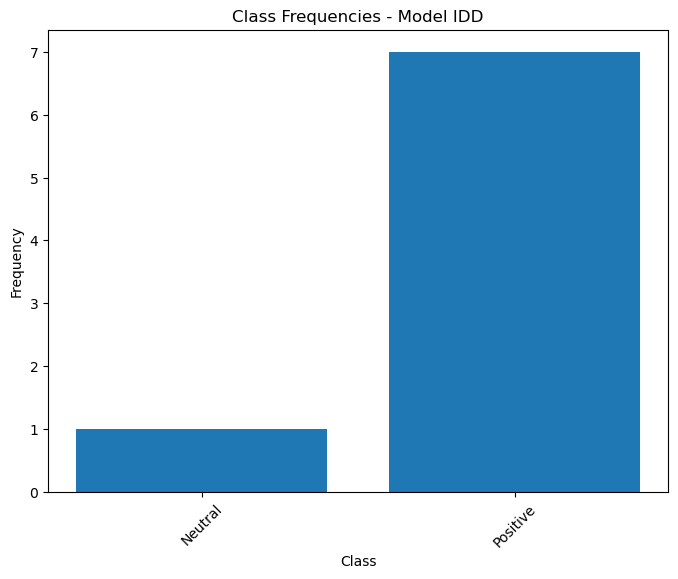

In [219]:
# Obtain the classification report for Model IDD
report_model_idd = classification_report(y_test_idd, pred_model_idd, output_dict=True)

# Get the class labels and their corresponding frequencies
class_labels_idd = list(report_model_idd.keys())[:-3]
class_frequencies_idd = [report_model_idd[label]['support'] for label in class_labels_idd]
class_labels_idd = [int(label) for label in class_labels_idd]

# Plot the class frequencies for Model IDD
plt.figure(figsize=(8, 6))
plt.bar(lb.inverse_transform(class_labels_idd), class_frequencies_idd)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Frequencies - Model IDD')
plt.xticks(rotation=45)
plt.show()


In [220]:
#classification report for Model IDD
report_model_idd = classification_report(y_test_idd, pred_model_idd, output_dict=True)

# Get the class labels and their corresponding frequencies
class_labels_idd = list(report_model_idd.keys())[:-3]
class_frequencies_idd = [report_model_idd[label]['support'] for label in class_labels_idd]
class_labels_idd = [int(label) for label in class_labels_idd]

# Cfrequency table
frequency_table_idd = pd.DataFrame({
    'Class': class_labels_idd,
    'Frequency': class_frequencies_idd
})

# Display the frequency table
print(frequency_table_idd)

   Class  Frequency
0      1          1
1      2          7


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


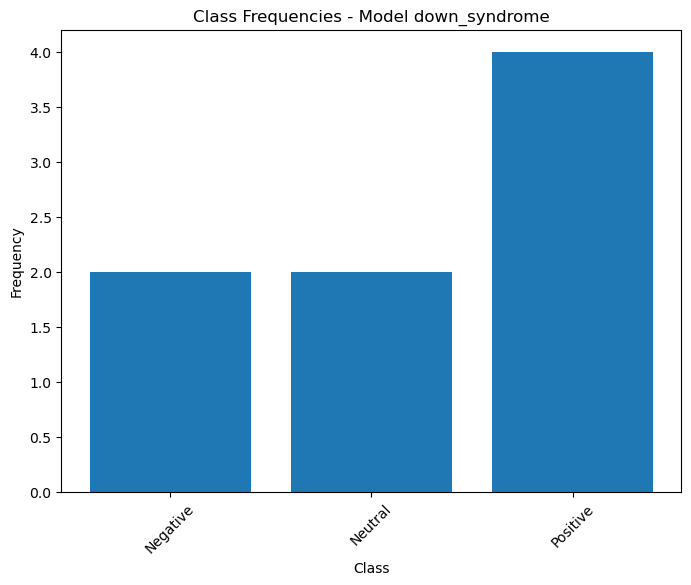

In [221]:
# Obtain the classification report for Model down syndrome
report_model_down_syndrome = classification_report(y_test_down_syndrome, pred_model_down_syndrome, output_dict=True)

# Get the class labels and their corresponding frequencies
class_labels_down_syndrome = list(report_model_down_syndrome.keys())[:-3]
class_frequencies_down_syndrome = [report_model_down_syndrome[label]['support'] for label in class_labels_down_syndrome]
class_labels_down_syndrome = [int(label) for label in class_labels_down_syndrome]

# Plot the class frequencies for Model down syndrome
plt.figure(figsize=(8, 6))
plt.bar(lb.inverse_transform(class_labels_down_syndrome), class_frequencies_down_syndrome)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Frequencies - Model down_syndrome')
plt.xticks(rotation=45)
plt.show()


In [222]:
# Obtain the classification report for Model down syndromw
report_model_down_syndrome = classification_report(y_test_down_syndrome, pred_model_down_syndrome, output_dict=True)

# Get the class labels and their corresponding frequencies
class_labels_down_syndrome = list(report_model_down_syndrome.keys())[:-3]
class_frequencies_down_syndrome = [report_model_down_syndrome[label]['support'] for label in class_labels_down_syndrome]
class_labels_down_syndrome = [int(label) for label in class_labels_down_syndrome]

# Create a DataFrame for the frequency table
frequency_table_down_syndrome = pd.DataFrame({
    'Class': class_labels_down_syndrome,
    'Frequency': class_frequencies_down_syndrome
})

# Display the frequency table
print(frequency_table_down_syndrome)

   Class  Frequency
0      0          2
1      1          2
2      2          4


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
